In [1]:
import string
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
import numpy as np
from spacy.lang.en.stop_words import STOP_WORDS
import utility_functions as utils
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Octis is the library which can use different implemented topic modelling techniques
from octis.preprocessing.preprocessing import Preprocessing
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.models.CTM import CTM

importlib.reload(utils)

data = '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Audio/test.json'

custom_stop_words = list(STOP_WORDS)  # Existing stop words
custom_stop_words.extend(["ll", "ve", "'em", "em", "ho", "fo", "ah", "de"])  # Tokens which doesn't really make sense to have them.

/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [14]:
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_data.xlsx', engine='openpyxl')

In [15]:
# I apply a general cleanup function to the lyrics (Either way it gets preprocessed later with Octis)
df['Lyrics'] = df['Lyrics'].apply(utils.cleanup) 

In [ ]:
# We need to export the lyrics line-by-line into a corpus.tsv so it can be used with Octis
with open('corpus.tsv', 'w', encoding='utf-8') as file:
    for lyrics in df['Lyrics']:
        if pd.notna(lyrics):  # Check if the lyrics data is not NaN
            file.write(lyrics + '\n')

In [16]:
# Initialize preprocessing
preprocessor = Preprocessing(
    vocabulary=None,
    max_features=None,
    remove_punctuation=True,
    punctuation=string.punctuation,
    lemmatize=True,
    stopword_list=custom_stop_words,
    min_chars=2,
    min_words_docs=0,
    save_original_indexes=True,
    min_df=0.05, # a term must appear in at least 5% of the documents; otherwise, it will be discarded.
    max_df=0.80, # a term appearing in more than 80% of the documents will be discarded, as it might be too common and potentially less informative.
    split=False # We don't want train, validation and test split
)

dataset = preprocessor.preprocess_dataset(documents_path="/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Lyrics/octis_dataset/corpus.tsv")

100%|██████████| 1360/1360 [02:01<00:00, 11.23it/s]

created vocab
647


In [17]:
# I save the dataset because it exports a file called indexes.txt. It is important because during the preprocessing steps the preprocessor
# can get rid of a few documents if they don't have enough words or maybe they are too short. (For example intro files).
# I can load the indexes.txt file and use it as a list of indexes and apply it on the original dataframe so I don't have size mismatch.
dataset.save('./')

In [20]:
best_coherence = -1
best_diversity = -1
best_params = {}
topic_nums = [2, 3, 4, 5, 10]
epoch_nums = [100, 200, 300]

for num_topics in topic_nums:
    for num_epochs in epoch_nums:
        # Initialize and train the CTM model
        model = CTM(num_topics=num_topics, inference_type="combined", num_epochs=num_epochs, use_partitions=False, bert_model="bert-base-nli-mean-tokens")
        model_output = model.train_model(dataset)

        # Calculate Coherence Score
        coherence = Coherence(texts=dataset.get_corpus(), topk=10)  # Adjust 'topk' as needed
        coherence = coherence.score(model_output)

        # Calculate Topic Diversity
        diversity_model = TopicDiversity(topk=10)
        diversity = diversity_model.score(model_output)

        # Evaluate based on coherence
        if coherence > best_coherence or (coherence == best_coherence and diversity > best_diversity):
            best_coherence = coherence
            best_diversity = diversity
            best_params = {'num_topics': num_topics, 'num_epochs': num_epochs}

        with open(f'ctm_model_{num_topics}_{num_epochs}.pkl', 'wb') as f:
            pickle.dump(model, f)

print(f"Best Coherence: {best_coherence}")
print(f"Best Diversity: {best_diversity}")
print(f"Best Parameters: {best_params}")

Best Coherence: 0.03669346350124248
Best Diversity: 1.0
Best Parameters: {'num_topics': 2, 'num_epochs': 300}


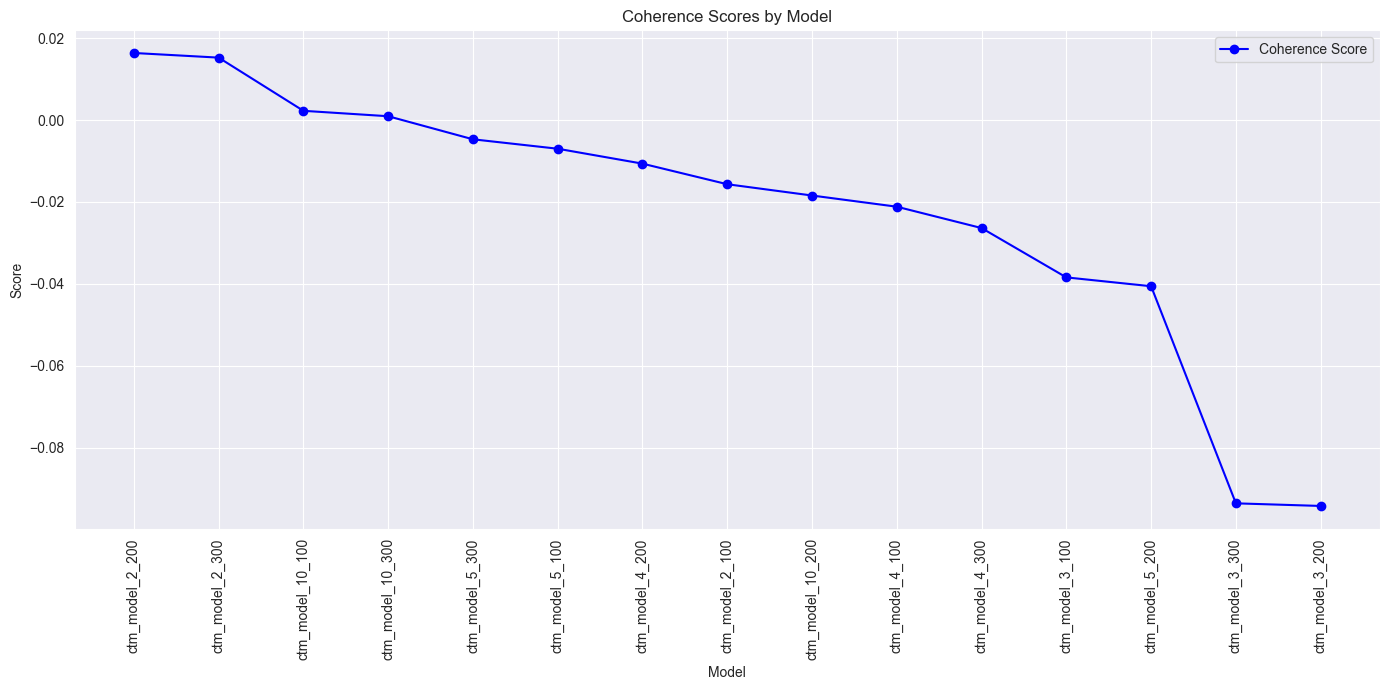

In [23]:
import os

model_directory = '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Lyrics/octis_dataset/CTM_Models'
model_files = [f for f in os.listdir(model_directory) if f.endswith('.pkl')]

# Lists to store metrics for plotting
coherence_scores = []
labels = []

for model_file in model_files:
    with open(os.path.join(model_directory, model_file), 'rb') as file:
        model = pickle.load(file)

    model_output = model.train_model(dataset)

    coherence = Coherence(texts=dataset.get_corpus(), topk=10)
    coherence_score = coherence.score(model_output)

    # Store results
    coherence_scores.append(coherence_score)
    labels.append(model_file.replace('.pkl', ''))

# Combine labels and coherence_scores for sorting
model_scores = list(zip(labels, coherence_scores))

# Sort models based on coherence score
model_scores_sorted = sorted(model_scores, key=lambda x: x[1], reverse=True)

# Unzip sorted lists
labels_sorted, coherence_scores_sorted = zip(*model_scores_sorted)

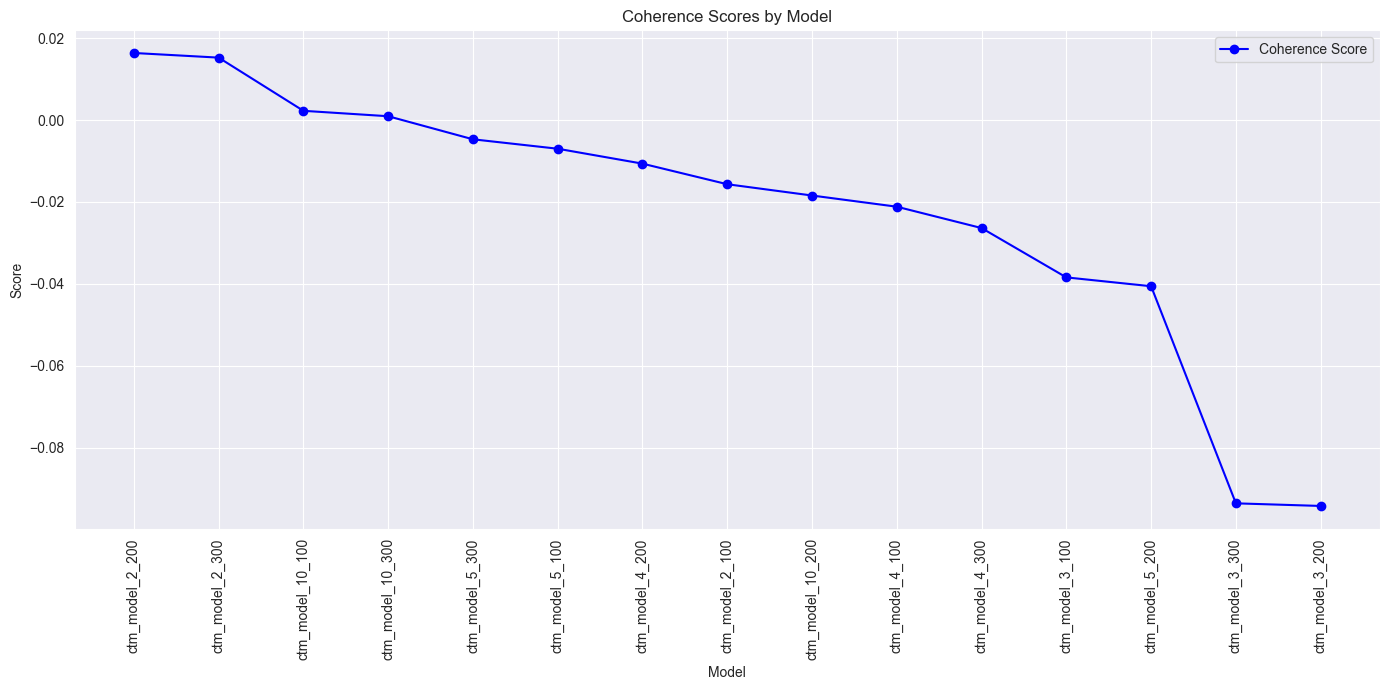

In [24]:
# Plotting coherence scores
plt.figure(figsize=(14, 7))
plt.plot(labels_sorted, coherence_scores_sorted, label='Coherence Score', marker='o', color='blue')
plt.title('Coherence Scores by Model')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('topic_coherence_by_model_type.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# model = CTM(num_topics=best_params['num_topics'], inference_type="combined", num_epochs=best_params['num_epochs'], use_partitions=False, bert_model="bert-base-nli-mean-tokens")

# Load the model instead
with open("/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Lyrics/octis_dataset/CTM_Models/ctm_model_2_300.pkl", 'rb') as file:
    model = pickle.load(file)
    
model_output = model.train_model(dataset)

In [32]:
coherence = Coherence(texts=dataset.get_corpus(), topk=10)  # Adjust 'topk' as needed
topic_diversity = TopicDiversity(topk=10)
coherence_score = coherence.score(model_output)
diversity_score = topic_diversity.score(model_output)

print("Coherence Score:", coherence_score)
print("Diversity Score:", diversity_score)

Coherence Score: -0.007276784242497292
Diversity Score: 1.0


In [33]:
# We decide on the topic based on the maximum probability of the topic.
dominant_topic_indices = np.argmax(model_output['topic-document-matrix'], axis=0)

In [34]:
dominant_topics = []
for i in dominant_topic_indices:
    dominant_topics.append(model_output['topics'][i])


In [35]:
# We load the previously saved indexes file because in this way we can filter the documents by index. Some documents may not included in the analysis due to the preprocessing steps
file_path = 'indexes.txt'
with open(file_path, 'r') as file:
    indices = [int(line.strip()) for line in file]

In [36]:
filtered_df = df.iloc[indices]

In [37]:
# This is just to make sure that in the filtered dataframe we have the same ammount of songs than in the preprocessed dataset.
filtered_df.shape[0] == dominant_topic_indices.shape[0]

True

In [38]:
filtered_df['Topic Model Index'] = dominant_topic_indices
filtered_df['Topic Model'] = dominant_topics

In [39]:
filtered_df

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,Lyrics,Topic Model,Named_Entities,Topic Model Index
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yeah my crew be in the house terra herb mcgruf...,"[nigga, thug, think, bitch, fuck, shit, come, ...","[{'entity': 'Terra', 'type': 'PER', 'score': 0...",1
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,it be the number one crew in the area big l be...,"[nigga, thug, think, bitch, fuck, shit, come, ...","[{'entity': 'Big', 'type': 'PER', 'score': 0.5...",1
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,there be too many mc 's who be overrate yeah a...,"[la, power, cuz, rhyme, guy, jam, funky, cut, ...","[{'entity': 'L', 'type': 'PER', 'score': 0.571...",0
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,let I get to the point real quick when yeah po...,"[la, power, cuz, rhyme, guy, jam, funky, cut, ...","[{'entity': 'Benz', 'type': 'MISC', 'score': 0...",0
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,a yeah spark up the phillie and pass the stout...,"[la, power, cuz, rhyme, guy, jam, funky, cut, ...","[{'entity': 'L', 'type': 'PER', 'score': 0.444...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,Dr.Dre,The Chronic,Dr. Dre - The Day the Niggaz Took Over (feat. ...,west_coast,1992,93.750000,46.875000,273.206000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yeah nigga what be up with all that motherfuck...,"[nigga, thug, think, bitch, fuck, shit, come, ...","[{'entity': 'Lucifer', 'type': 'PER', 'score':...",1
1356,Dr.Dre,The Chronic,"Dr. Dre - Bitches Ain't Shit (feat. Jewell, Sn...",west_coast,1992,92.307692,46.153846,287.207625,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,— so all of yeah african all of yeah african t...,"[nigga, thug, think, bitch, fuck, shit, come, ...","[{'entity': 'Africans', 'type': 'MISC', 'score...",1
1357,Dr.Dre,The Chronic,Dr. Dre - Stranded On Death Row (feat. Bushwic...,west_coast,1992,90.909091,45.801527,287.335333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yeah really do not understand do yeah hey man ...,"[nigga, thug, think, bitch, fuck, shit, come, ...","[{'entity': 'Death Row', 'type': 'ORG', 'score...",1
1358,Dr.Dre,The Chronic,Dr. Dre - Nuthin' but a ＂G＂ Thang (feat. Snoop...,west_coast,1992,95.238095,47.244094,238.677917,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yeah yeah what be up yeah man give I some of t...,"[nigga, thug, think, bitch, fuck, shit, come, ...","[{'entity': 'RBX', 'type': 'ORG', 'score': 0.7...",1


In [97]:
filtered_df.to_excel('baseline_w_topics_w_entity.xlsx', index=False)

In [40]:
topic_coast_distribution = pd.crosstab(filtered_df['Topic Model Index'], filtered_df['Coast'])
print(topic_coast_distribution)

Coast              east_coast  west_coast
Topic Model Index                        
0                         421         234
1                         273         432


In [41]:
# Normalization of the topic distribution over the entire dataset
total_songs = topic_coast_distribution.sum().sum()
topic_coast_distribution_normalized = topic_coast_distribution / total_songs

In [42]:
model_output['topics']

[['la',
  'power',
  'cuz',
  'rhyme',
  'guy',
  'jam',
  'funky',
  'cut',
  'record',
  'king'],
 ['nigga',
  'thug',
  'think',
  'bitch',
  'fuck',
  'shit',
  'come',
  'want',
  'tell',
  'hoe']]

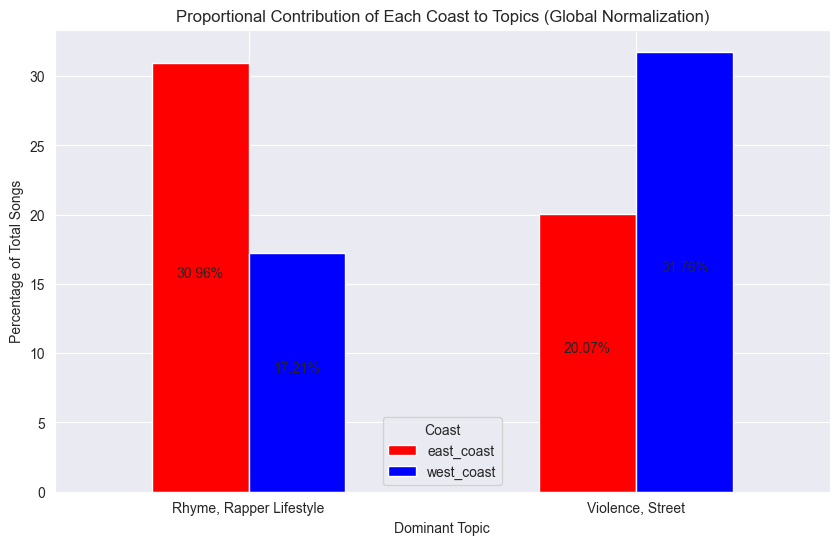

In [43]:
# Assuming topic_coast_distribution_normalized is already defined
colors = ['red', 'blue']
topic_labels = ['Rhyme, Rapper Lifestyle', 'Violence, Street']

# Create the bar plot
ax = (topic_coast_distribution_normalized * 100).plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Proportional Contribution of Each Coast to Topics (Global Normalization)')
plt.xlabel('Dominant Topic')
plt.ylabel('Percentage of Total Songs')
plt.xticks(rotation=0)
plt.legend(title='Coast')

# Change the x-axis labels to the topic descriptions
ax.set_xticklabels(topic_labels)

# Adding percentage labels
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Only add annotations for non-zero values
        ax.annotate(f'{height:.2f}%', (x + width/2, y + height*0.5), ha='center')

plt.savefig('coast_topic_contribution.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()